In [1]:
#!pip install tensorflow==2.13.1
#!pip install polars keras==2.13.1

In [2]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import backend as K
import tensorflow as tf
print(tf.__version__)

import os
import polars as pl
import pandas as pd#
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
# from kan import *
import torch
from matplotlib import pyplot as plt

2024-08-16 13:25:10.129690: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-16 13:25:10.131695: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-16 13:25:10.174807: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-16 13:25:10.175907: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 13:25:18.652859: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

2.13.1


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("REPLICAS: ", strategy.num_replicas_in_sync)
except ValueError:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE

# Read data

In [77]:
%%time
train_df = pl.read_parquet('/n/holystore01/LABS/itc_lab/Users/sjeffreson/GalactISM/GalactISM_ETG-lowM+MW.parquet')
test_df = pl.read_parquet('/n/holystore01/LABS/itc_lab/Users/sjeffreson/GalactISM/GalactISM_ETG-medM.parquet')

CPU times: user 209 ms, sys: 107 ms, total: 316 ms
Wall time: 333 ms


In [78]:
# print the columns of train_df
print(train_df.columns)

['galaxy', 'weight', 'rotcurve', 'kappa', 'gas_surfdens', 'gas_surfdens_cw', 'star_surfdens', 'SFR_surfdens', 'H2_mass', 'HI_mass', 'H2HI_mass', 'gas_voldens_midplane', 'gas_voldens_midplane_cw', 'star_voldens_midplane', 'veldisp_midplane', 'Pturb', 'Ptherm', 'R/Router', '__index_level_0__']


In [79]:
features = ['rotcurve', 'kappa', 'gas_surfdens', 'star_surfdens']#, 'R/Router']
#log_features = ['kappa', 'gas_surfdens', 'star_surfdens']
print(len(features))

4


In [80]:
targets = ['weight', 'gas_surfdens_cw', 'SFR_surfdens', 'H2_mass', 'HI_mass', 'H2HI_mass', 'gas_voldens_midplane', 'gas_voldens_midplane_cw', 'star_voldens_midplane',
           'Pturb', 'Ptherm', 'veldisp_midplane']
# log_targets = ['weight', 'gas_surfdens_cw', 'SFR_surfdens', 'H2_mass', 'HI_mass', 'H2HI_mass', 'gas_voldens_midplane', 'gas_voldens_midplane_cw', 'star_voldens_midplane',
#               'veldisp_midplane']
log_targets = []
print(len(targets))

12


In [81]:
X_train = train_df.select(features).to_numpy()
y = train_df.select(targets).to_numpy()
test_feats = test_df.select(features).to_numpy()
print(X_train.shape, y.shape, test_feats.shape)

(919684, 4) (919684, 12) (592800, 4)


# Standard scalar

In [82]:
# random-shuffle all the data
np.random.seed(42)
idx = np.arange(X_train.shape[0])
np.random.shuffle(idx)
X_train = X_train[idx]
y = y[idx]

In [83]:
# # log the log_variables and add a small amount of noise (for zero values), equivalent
# # to about 1% of the smallest value
# for i, col in enumerate(log_targets):
#     if col in targets:
#         y[:, i] = np.log10(y[:, i] + 1e-2 * min(y[:, i][y[:, i] > 0]))

# for i, col in enumerate(log_features):
#     if col in features:
#         min_val = min(X_train[:, i][X_train[:, i] > 0])
#         X_train[:, i] = np.log10(X_train[:, i] + 1e-2 * min_val)
#         test_feats[:, i] = np.log10(test_feats[:, i] + 1e-2 * min_val)

In [84]:
# norm X
mx = X_train.mean(axis=0)
sx = X_train.std(axis=0)
X_train = (X_train - mx.reshape(1,-1)) / sx.reshape(1,-1)
test_feats = (test_feats - mx.reshape(1,-1)) / sx.reshape(1,-1)

# norm Y
my = y.mean(axis=0)
sy = np.sqrt((y*y).mean(axis=0))
y = (y - my.reshape(1,-1)) / sy.reshape(1,-1)


In [85]:
# # plot histograms of features, one by one
# for i, col in enumerate(features):
#     plt.hist(X_train[:, i], bins=100, log=True, histtype='step', lw=2)
#     plt.title(col)
#     plt.show()

In [86]:
# # plot histograms of targets, one by one
# for i, col in enumerate(targets):
#     plt.hist(y[:, i], bins=100, histtype='step', label=col, log=True)
#     plt.legend()
#     plt.show()

# Build MLP model

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

In [15]:
print(y.shape)

(919684, 12)


In [16]:
def mlp_model():
    # hyperparameters
    hidden_size = X_train.shape[1] + y.shape[1] # size of the hidden layers in the network
    inp_shape = X_train.shape[1] # shape of the inputs to the model
    n_layers = 5 # number of layers
    activation_fn = 'leakyRelu'

    # define the MLP model
    inputs = tf.keras.Input(shape=(inp_shape,),name='input')
    x = inputs
    x = tf.keras.layers.Dense(3*hidden_size)(x)
    x = tf.keras.layers.Dense(2*hidden_size)(x)
    x1 = x
    for i in range(n_layers):       
        x = tf.keras.layers.Dense(2*hidden_size)(x)
        if activation_fn=='relu':
            x = tf.keras.layers.ReLU()(x) 
        elif activation_fn=='elu':
            x = tf.keras.layers.ELU()(x)
        elif activation_fn=='leakyRelu':
            x = tf.keras.layers.LeakyReLU(alpha=.15)(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        if (i+1) % 2 == 0:
            x = tf.keras.layers.add([x, x1])
            x1 = x

    x = tf.keras.layers.Dense(3*hidden_size)(x)
    outputs  = tf.keras.layers.Dense(y.shape[1])(x)

    model = tf.keras.Model(inputs,outputs) # instantiate the MLP model

    return model

In [17]:
mlp_model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 4)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 48)                   240       ['input[0][0]']               
                                                                                                  
 dense_1 (Dense)             (None, 32)                   1568      ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 32)                   1056      ['dense_1[0][0]']             
                                                                                              

# cosine scheduler

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger('tensorflow').setLevel(logging.ERROR)

from tensorflow.keras.callbacks import Callback

In [19]:
class CosineAnnealer:
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0

    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.01, div_factor=10.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 10)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps

        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0

        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)],
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]

        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)

    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1

        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())

    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None

    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None

    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore

    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]

    def mom_schedule(self):
        return self.phases[self.phase][1]

    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

def scheduler(epoch, lr):
    if epoch < 1 or epoch > 1:
        return lr
    else:
        return lr / (25 * 10)

def lr_warmup_cosine_decay(global_step,
                           warmup_steps,
                           hold = 0,
                           total_steps=0,
                           start_lr=0.0,
                           target_lr=1e-3):
    # Cosine decay
    learning_rate = 0.5 * target_lr * (1 + np.cos(np.pi * (global_step - warmup_steps - hold) / float(total_steps - warmup_steps - hold)))

    # Target LR * progress of warmup (=1 at the final warmup step)
    warmup_lr = target_lr * (global_step / warmup_steps)

    # Choose between `warmup_lr`, `target_lr` and `learning_rate` based on whether `global_step < warmup_steps` and we're still holding.
    # i.e. warm up if we're still warming up and use cosine decayed lr otherwise
    if hold > 0:
        learning_rate = np.where(global_step > warmup_steps + hold,
                                 learning_rate, target_lr)

    learning_rate = np.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate

# compile and fit the model

In [21]:
EPOCH = 10
BATCH_SIZE = 3072 * strategy.num_replicas_in_sync
print(BATCH_SIZE)
EARLY_PATIENCE = 20
MAX_LR = 0.0001

3072


In [22]:
# custom evaluation metric
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred ), axis=0)
    SS_tot = K.sum(K.square( y_true - K.mean(y_true,axis=0)), axis=0)
    R2 = (1 - SS_res/(SS_tot + K.epsilon()))
    return K.mean(R2)

In [23]:
# start with one epoch
model = mlp_model()
kf = KFold(n_splits=20, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y)):

    checkpoint_filepath = f"folds{fold}.weights.h5"

    K.clear_session()
    with strategy.scope():

        optimizer = tf.keras.optimizers.Adam(learning_rate=MAX_LR, clipnorm=0.1)
        model.compile(optimizer=optimizer, loss='mse', metrics=[R2])

    monitor = "val_loss"
    sv = ModelCheckpoint(
            checkpoint_filepath, monitor=monitor, verbose=1, save_best_only=True,
            save_weights_only=True, mode='min', save_freq='epoch'
    )
    steps = (len(train_idx) // BATCH_SIZE) * EPOCH
    lr_schedule = OneCycleScheduler(lr_max=MAX_LR, steps=steps)

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor=monitor,
        min_delta=0.0,
        patience=EARLY_PATIENCE,
        mode="min"
    )

    history = model.fit(X_train[train_idx], y[train_idx], verbose=1,
                        validation_data=(X_train[val_idx], y[val_idx]),
                        epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr_schedule, sv, early_stop]) 
    break

Epoch 1/10
283/285 [============================>.] - ETA: 0s - loss: 1.5185 - R2: -1.2228
Epoch 1: val_loss improved from inf to 0.45030, saving model to folds0.weights.h5
285/285 [==============================] - 7s 15ms/step - loss: 1.5147 - R2: -1.2183 - val_loss: 0.4503 - val_R2: 0.4973
Epoch 2/10
284/285 [============================>.] - ETA: 0s - loss: 0.7064 - R2: 0.0933
Epoch 2: val_loss improved from 0.45030 to 0.32751, saving model to folds0.weights.h5
285/285 [==============================] - 4s 14ms/step - loss: 0.7059 - R2: 0.0938 - val_loss: 0.3275 - val_R2: 0.6556
Epoch 3/10
282/285 [============================>.] - ETA: 0s - loss: 0.4908 - R2: 0.4512
Epoch 3: val_loss improved from 0.32751 to 0.30526, saving model to folds0.weights.h5
285/285 [==============================] - 4s 14ms/step - loss: 0.4894 - R2: 0.4524 - val_loss: 0.3053 - val_R2: 0.6865
Epoch 4/10
282/285 [============================>.] - ETA: 0s - loss: 0.4301 - R2: 0.5505
Epoch 4: val_loss improv

In [24]:
# save the weights
model.save_weights("epoch10-MLP.h5")

In [25]:
import gc
gc.collect()

3634

# evaluate model performance

In [87]:
model.load_weights("epoch10-MLP.h5")
y_pred = model.predict(X_train[val_idx])
y_true = y[val_idx]

1438/1438 [==============================] - 2s 1ms/step


In [88]:
# denormalize
y_pred = y_pred * sy + my
y_true = y_true * sy + my

# # convert back from log
# for i, col in enumerate(log_targets):
#     print('hello')
#     if col in targets:
#         y_pred[:, i] = 10**y_pred[:, i]
#         y_true[:, i] = 10**y_true[:, i]

In [89]:
# because the surfdens of the cool-warm gas is quite a good prediction, we could use it
# as a feature to predict the other targets

/tmp/ipykernel_1302278/4096668969.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(y_true[:,0]), np.log10(y_true[:,2]), alpha=0.1)
/tmp/ipykernel_1302278/4096668969.py:2: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(y_pred[:,0]), np.log10(y_pred[:,2]), alpha=0.1)


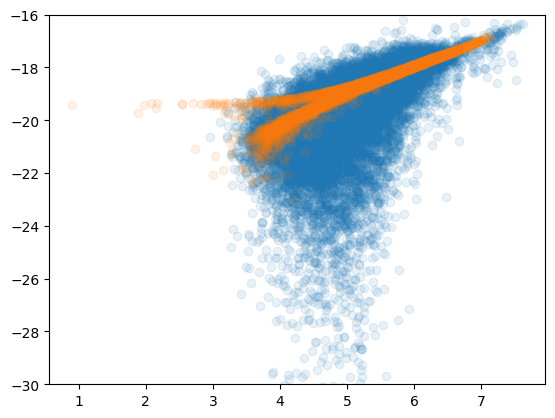

In [90]:
plt.scatter(np.log10(y_true[:,0]), np.log10(y_true[:,2]), alpha=0.1)
plt.scatter(np.log10(y_pred[:,0]), np.log10(y_pred[:,2]), alpha=0.1)
plt.ylim(-30., -16.)
plt.show()

In [91]:
# average performance across all targets
print("R2: ", r2_score(y_true=y_true, y_pred=y_pred, multioutput='uniform_average'))

R2:  0.6646453219998555


In [92]:
# check individual targets R2
for i,j in zip(targets, r2_score(y_true=y_true, y_pred=y_pred, multioutput='raw_values').tolist()):
    print(i,' = ',j)

weight  =  0.626081782582306
gas_surfdens_cw  =  0.9674228328593918
SFR_surfdens  =  0.5123729023420129
H2_mass  =  0.943577161961609
HI_mass  =  0.8628248063883078
H2HI_mass  =  0.9667706519510024
gas_voldens_midplane  =  0.7477151035076288
gas_voldens_midplane_cw  =  0.7505089223660087
star_voldens_midplane  =  0.406479292567147
Pturb  =  0.3803945659576441
Ptherm  =  0.45809877570576896
veldisp_midplane  =  0.35349706580943896


# Inference and save in the sample submission file

In [93]:
# predict using the test features
y_pred = model.predict(test_feats)

# unstandardize the predictions
y_pred = y_pred * sy.reshape(1,-1) + my.reshape(1,-1)

    1/18525 [..............................] - ETA: 7:00

18525/18525 [==============================] - 21s 1ms/step


In [94]:
y_true = test_df.select(targets).to_numpy()

In [95]:
print(targets)

['weight', 'gas_surfdens_cw', 'SFR_surfdens', 'H2_mass', 'HI_mass', 'H2HI_mass', 'gas_voldens_midplane', 'gas_voldens_midplane_cw', 'star_voldens_midplane', 'Pturb', 'Ptherm', 'veldisp_midplane']


/tmp/ipykernel_1302278/3118872796.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(y_true[:,9]), np.log10(y_true[:,2]), alpha=0.1)


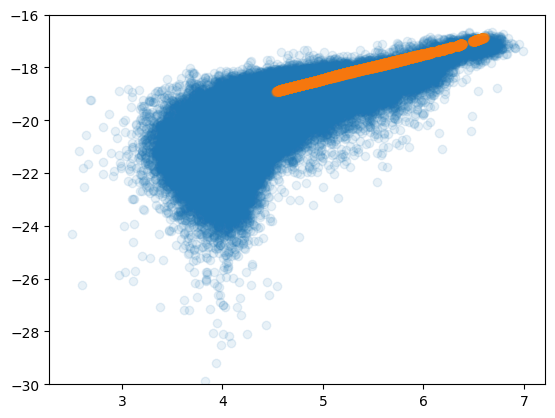

In [96]:
plt.scatter(np.log10(y_true[:,9]), np.log10(y_true[:,2]), alpha=0.1)
plt.scatter(np.log10(y_pred[:,9]), np.log10(y_pred[:,2]), alpha=0.1)
plt.ylim(-30., -16.)
plt.show()

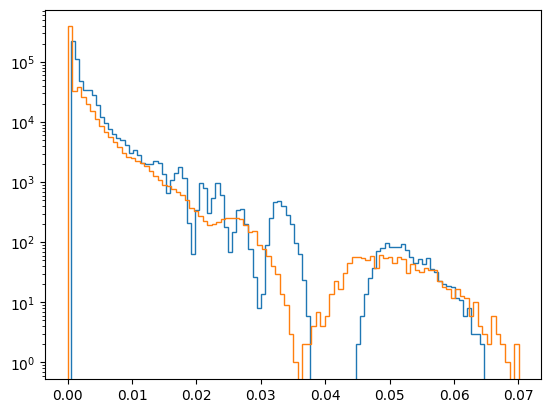

In [97]:
plt.hist(y_pred[:,3], bins=100, log=True, histtype='step')
plt.hist(y_true[:,3], bins=100, log=True, histtype='step')
plt.show()

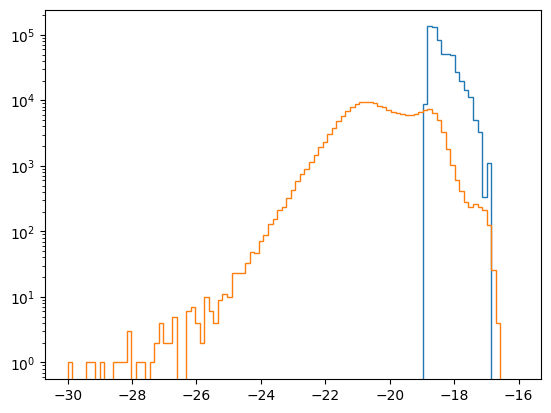

In [98]:
plt.hist(np.log10(y_pred[:,2]+1.e-50), bins=np.linspace(-30., -16, 100), log=True, histtype='step')
plt.hist(np.log10(y_true[:,2]+1.e-50), bins=np.linspace(-30., -16, 100), log=True, histtype='step')
plt.show()

In [99]:
print("R2: ", r2_score(y_true=y_true, y_pred=y_pred, multioutput='raw_values').tolist())
# print the overall R2
print("R2: ", r2_score(y_true=y_true, y_pred=y_pred, multioutput='uniform_average'))

R2:  [0.10436138428298447, 0.42254610475903087, -8.16158214737983, 0.805534558143594, -7.830154215309742, 0.3723544959569598, 0.14393369942065837, 0.14449881577127954, 0.7611087929363229, -2.1709906889541837, -4.0614551249830475, 0.4093444920317053]
R2:  -1.5883749861103558
